# Category Prediction with Threshold Analysis

This notebook builds a predictive model for automatic transaction categorization using keyword-based scoring. It includes threshold optimization, model evaluation (precision, recall, F1-score), and visualization of classification performance.

## Workflow
1. Load and normalize transaction data
2. Extract keywords from a reference category
3. Calculate frequency-based scores for each keyword
4. Compute narration scores by aggregating keyword matches
5. Determine optimal classification threshold
6. Evaluate model performance with confusion matrix
7. Visualize score distributions and thresholds

## Performance Metrics
- True Positives (TP): Correct category predictions
- False Negatives (FN): Missed category predictions
- False Positives (FP): Incorrect category predictions
- True Negatives (TN): Correct non-category predictions

In [ ]:
# Import required libraries
import pandas as pd  # Data manipulation
import numpy as np   # Numerical operations
import re            # Text processing
from collections import Counter  # Count keyword frequencies

In [ ]:
# Load transaction data
all_df = pd.read_excel("all.xlsx")

In [ ]:
# Select reference category for analysis
# This category will be used to build the prediction model
ref_category = "Dividend Income"

In [ ]:
# Filter dataframe to get only transactions in the reference category
ref_df = all_df[all_df['Category'] == ref_category]

In [ ]:
def normalize(text):
    """
    Normalize transaction narration for consistent analysis.
    
    Process:
    - Lowercase conversion
    - Remove special characters
    - Collapse whitespace
    
    Args:
        text (str): Raw narration text
        
    Returns:
        str: Normalized text
    """
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9 ]", " ", text)  # Keep only alphanumeric + spaces
    text = re.sub(r"\s+", " ", text)  # Collapse whitespace
    return text.strip()

In [ ]:
# Normalize narrations for all transactions and reference category
all_df["narr_norm"] = all_df["Narration"].apply(normalize)
ref_df["narr_norm"] = ref_df["Narration"].apply(normalize)

C:\Users\subha\AppData\Local\Temp\ipykernel_22580\3145485645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df["narr_norm"] = ref_df["Narration"].apply(normalize)


In [ ]:
# Build keyword frequency scores from reference category transactions
# Extract all tokens from reference narrations
tokens = []
for n in ref_df["narr_norm"]:
    tokens.extend(n.split())

# Count token frequencies
freq = Counter(tokens)
max_freq = max(freq.values())

# Normalize scores to 0-100 scale (percentage of max frequency)
KEYWORD_SCORE = {
    k: (v / max_freq) * 100
    for k, v in freq.items()
}

In [ ]:
def narration_score(narr):
    """
    Calculate aggregated score for a narration based on keyword frequencies.
    
    Sums up the scores of all keywords found in the narration.
    
    Args:
        narr (str): Normalized narration text
        
    Returns:
        float: Total score for the narration
    """
    return sum(KEYWORD_SCORE.get(t, 0) for t in narr.split())

# Apply scoring function to all narrations
all_df["narr_score"] = all_df["narr_norm"].apply(narration_score)

In [ ]:
# Group transactions by normalized narration and sort by date
# This helps identify patterns and recurring narrations
groups = {
    k: g.sort_values("Date")
    for k, g in all_df.groupby("narr_norm")
}

In [ ]:
# Store reference score (same as narr_score for now, can be extended)
all_df["ref_score"] = (
    all_df["narr_score"]
)

In [ ]:
# Create transaction key (normalized narration) for both datasets
all_df["tx_key"] = (
    all_df["narr_norm"]
)

ref_df["tx_key"] = (
    ref_df["narr_norm"]
)

# Create ground truth labels based on whether narration appears in reference
ref_keys = set(ref_df["tx_key"])

all_df["true_category"] = np.where(
    all_df["tx_key"].isin(ref_keys),
    ref_category,
    "Other"
)

C:\Users\subha\AppData\Local\Temp\ipykernel_22580\1240434657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df["tx_key"] = (


In [ ]:
# Define classification threshold
# Transactions with score >= THRESHOLD are predicted as ref_category
THRESHOLD = 70

all_df["predicted_category"] = np.where(
    all_df["ref_score"] >= THRESHOLD,
    ref_category,
    "Other"
)

In [ ]:
# Calculate confusion matrix elements
# TP: True Positives - correctly predicted as ref_category
# FN: False Negatives - missed predictions (should be ref_category, but predicted Other)
# FP: False Positives - incorrect predictions (predicted ref_category, but actually Other)
# TN: True Negatives - correctly predicted as Other

TP = (
    (all_df["true_category"] == ref_category) &
    (all_df["predicted_category"] == ref_category)
).sum()

FN = (
    (all_df["true_category"] == ref_category) &
    (all_df["predicted_category"] == "Other")
).sum()

FP = (
    (all_df["true_category"] == "Other") &
    (all_df["predicted_category"] == ref_category)
).sum()

TN = (
    (all_df["true_category"] == "Other") &
    (all_df["predicted_category"] == "Other")
).sum()

# Display confusion matrix
print("TP:", TP)
print("FN:", FN)
print("FP:", FP)
print("TN:", TN)

TP: 491
FN: 204
FP: 12308
TN: 501966


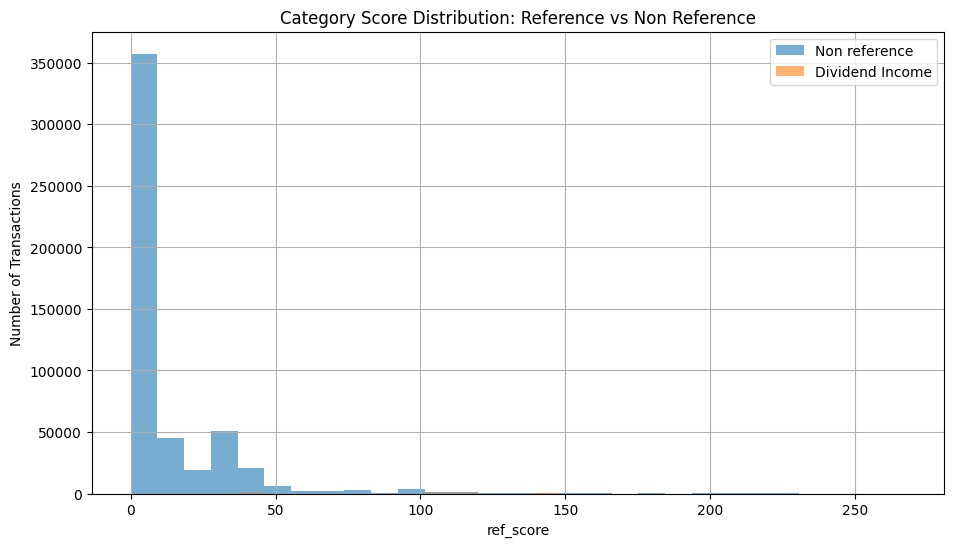

In [ ]:
# Visualize score distribution for reference vs non-reference transactions
import matplotlib.pyplot as plt
import numpy as np

# Separate scores for reference and non-reference transactions
ref = all_df[all_df['is_ref'] == 1]['ref_score'].dropna()
non_ref = all_df[all_df['is_ref'] == 0]['ref_score'].dropna()

# Create bins for histogram
bins = np.linspace(all_df['ref_score'].min(), all_df['ref_score'].max(), 30)

# Plot histogram
plt.figure(figsize=(11, 6))
plt.hist(non_ref, bins=bins, alpha=0.6, label='Non reference')
plt.hist(ref, bins=bins, alpha=0.6, label=ref_category)

plt.xlabel('ref_score')
plt.ylabel('Number of Transactions')
plt.title('Category Score Distribution: Reference vs Non Reference')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Create balanced dataset for better visualization
# Include all reference transactions and sample from non-reference
SAMPLE_SIZE = 2000
RANDOM_SEED = 42

ref_sample = all_df[all_df['is_ref'] == 1]
non_ref_df = all_df[all_df['is_ref'] == 0]

non_ref_sample = (
    non_ref_df.sample(
        n=min(SAMPLE_SIZE, len(non_ref_df)),
        random_state=RANDOM_SEED
    )
)

# Combine reference and sampled non-reference data
balanced_df = pd.concat([ref_sample, non_ref_sample])

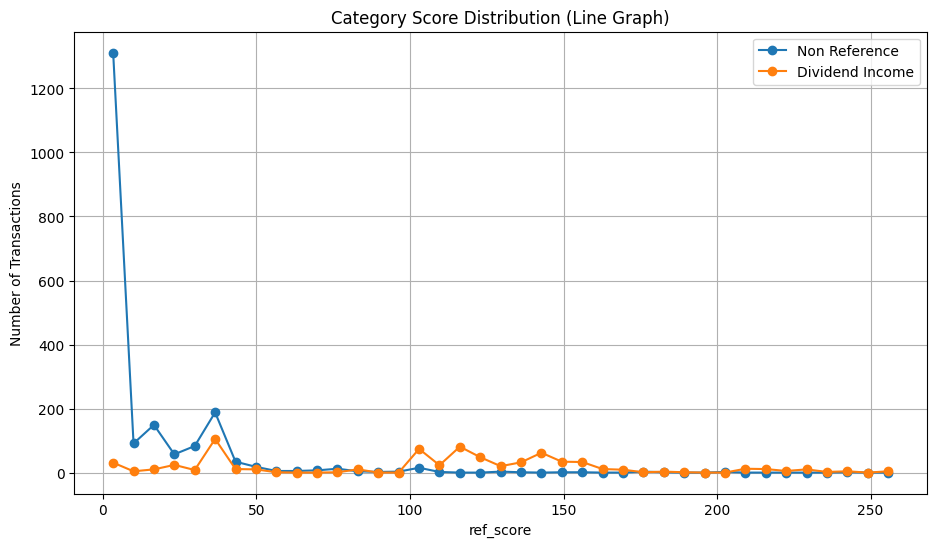

In [ ]:
# Plot line graph of score distribution for better visualization of separation
ref = balanced_df[balanced_df['is_ref'] == 1]['ref_score'].dropna()
non_ref = balanced_df[balanced_df['is_ref'] == 0]['ref_score'].dropna()

bins = np.linspace(
    balanced_df['ref_score'].min(),
    balanced_df['ref_score'].max(),
    40
)

# Get counts for each bin
ref_counts, _ = np.histogram(ref, bins=bins)
non_ref_counts, _ = np.histogram(non_ref, bins=bins)

# Calculate bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create line plot
plt.figure(figsize=(11, 6))
plt.plot(bin_centers, non_ref_counts, marker='o', label='Non Reference')
plt.plot(bin_centers, ref_counts, marker='o', label=ref_category)

plt.xlabel('ref_score')
plt.ylabel('Number of Transactions')
plt.title('Category Score Distribution (Line Graph)')
plt.legend()
plt.grid(True)

plt.show()